In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import numpy as np
from tensorflow.keras.preprocessing import image
from skimage.io import imread
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Dropout, Conv2D
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr


In [4]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data3/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

print(labelStringArr)

img_df.sample(n=10)

['ISL' 'PRT' 'CHE']


,path,label
106,/home/pascal_steiger/Downloads/data3/ISL/img_I...,ISL
1780,/home/pascal_steiger/Downloads/data3/PRT/img_P...,PRT
1801,/home/pascal_steiger/Downloads/data3/PRT/img_P...,PRT
524,/home/pascal_steiger/Downloads/data3/ISL/img_I...,ISL
2672,/home/pascal_steiger/Downloads/data3/CHE/img_4...,CHE
2099,/home/pascal_steiger/Downloads/data3/CHE/img_4...,CHE
972,/home/pascal_steiger/Downloads/data3/ISL/img_I...,ISL
1504,/home/pascal_steiger/Downloads/data3/PRT/img_P...,PRT
2140,/home/pascal_steiger/Downloads/data3/CHE/img_4...,CHE
3008,/home/pascal_steiger/Downloads/data3/CHE/img_4...,CHE


In [5]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)


                                                   path label
586   /home/pascal_steiger/Downloads/data3/ISL/img_I...   ISL
2546  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
2881  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
493   /home/pascal_steiger/Downloads/data3/ISL/img_I...   ISL
2443  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
(2409, 2)
                                                   path label
2614  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
324   /home/pascal_steiger/Downloads/data3/ISL/img_I...   ISL
436   /home/pascal_steiger/Downloads/data3/ISL/img_I...   ISL
1850  /home/pascal_steiger/Downloads/data3/PRT/img_P...   PRT
32    /home/pascal_steiger/Downloads/data3/ISL/img_I...   ISL
(603, 2)


In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

In [7]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(380, 380),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(380, 380),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 2409 validated image filenames belonging to 3 classes.
Found 603 validated image filenames belonging to 3 classes.


In [8]:
with tf.device("/device:GPU:1"):
    from tensorflow.keras.applications import EfficientNetB4
    tl_efnet = EfficientNetB4(include_top=True,weights="imagenet")
    tl_efnet = tf.keras.Model(tl_efnet.input, tl_efnet.layers[-2].output)
    
    for layer in tl_efnet.layers:
        layer.trainable = False

    for layer in tl_efnet.layers[-5:]:
        layer.trainable = True 
    

In [9]:
tl_efnet.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [10]:
with tf.device("/device:GPU:1"):

    I = Input(shape=(380, 380, 3))



    x = tl_efnet(I)



    dense = Dense(1024, activation='relu', name='denserelu')(x)
    
    dropout = Dropout(0.1)(dense)

    dense2 = Dense(512, activation='relu', name='denserelu2')(dropout)
    
    dropout2 = Dropout(0.1)(dense2)

    dense3 = Dense(3, activation='softmax', name='my_dense')(dropout2)



    new_model2 = tf.keras.Model(I, dense3)

    new_model2.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 1792)              17673823  
_________________________________________________________________
denserelu (Dense)            (None, 1024)              1836032   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
denserelu2 (Dense)           (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
my_dense (Dense)             (None, 3)                 1539

In [12]:
def unwrap_model(model):
    mdl = model.get_layer('model')
    inp = mdl.input
    out = model.get_layer('denserelu')(mdl.output)
    out = model.get_layer('dropout')(out)
    out = model.get_layer('denserelu2')(out)
    out = model.get_layer('dropout_1')(out)
    out = model.get_layer('my_dense')(out)
    return tf.keras.Model(inp, out)   
    
new_model2 = unwrap_model(new_model2)

    
new_model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [13]:
# define callbacks for early stopping

early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [14]:
with tf.device("/device:GPU:1"):
    new_model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

with tf.device("/device:GPU:1"):
    history = new_model2.fit(
          train_generator,
          epochs=200,
          verbose = 1,
          callbacks=callbacks,
          #steps_per_epoch=2000 // 32,
          validation_data=validation_generator)
    new_model2.save('CNN-TL_efficientNet-data3.h5')

Epoch 1/200
76/76 [==============================] - 111s 1s/step - loss: 0.4931 - sparse_categorical_accuracy: 0.8016 - val_loss: 0.3347 - val_sparse_categorical_accuracy: 0.8590
Epoch 2/200
76/76 [==============================] - 90s 1s/step - loss: 0.2734 - sparse_categorical_accuracy: 0.8983 - val_loss: 0.3327 - val_sparse_categorical_accuracy: 0.8972
Epoch 3/200
76/76 [==============================] - 92s 1s/step - loss: 0.2228 - sparse_categorical_accuracy: 0.9161 - val_loss: 0.2737 - val_sparse_categorical_accuracy: 0.9104
Epoch 4/200
76/76 [==============================] - 91s 1s/step - loss: 0.1915 - sparse_categorical_accuracy: 0.9286 - val_loss: 0.2253 - val_sparse_categorical_accuracy: 0.9204
Epoch 5/200
76/76 [==============================] - 91s 1s/step - loss: 0.1601 - sparse_categorical_accuracy: 0.9411 - val_loss: 0.2953 - val_sparse_categorical_accuracy: 0.9088
Epoch 6/200
76/76 [==============================] - 90s 1s/step - loss: 0.1660 - sparse_categorical_acc

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


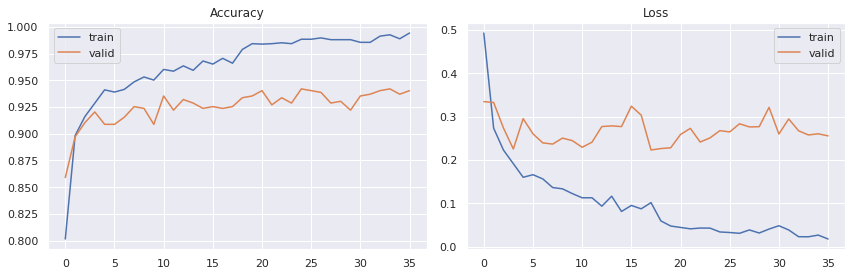

In [15]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(380,380)-tl_efficientnet-data3.png')

plt.show()

In [8]:
with tf.device("/device:GPU:1"):
    model2 = tf.keras.models.load_model('CNN-TL_efficientNet-data3.h5')

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=603
batch_size=32
with tf.device("/device:GPU:1"):
    Y_pred = model2.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = sorted(labelStringArr)
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[178   4  14]
 [  3 212   5]
 [  4   5 178]]
Classification Report
              precision    recall  f1-score   support

         CHE       0.96      0.91      0.93       196
         ISL       0.96      0.96      0.96       220
         PRT       0.90      0.95      0.93       187

    accuracy                           0.94       603
   macro avg       0.94      0.94      0.94       603
weighted avg       0.94      0.94      0.94       603

